# Test

## Import packages

In [7]:
import tensorflow_datasets as tfds

from tensorflow.lite.python.schema_py_generated import Model
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import torch
import os
import shutil
import pandas as pd
from timm.data import create_dataset
pd.set_option('display.max_rows', None)

In [8]:
from torchsummary import summary
model = timm.create_model('resnet50', pretrained=False)
summary(model, (3, 256, 256))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [9]:
model = timm.create_model('resnet50', pretrained=False)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
         Identity-10           [-1, 64, 64, 64]               0
             ReLU-11           [-1, 64, 64, 64]               0
         Identity-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
os.getcwd()

### Inspecting timm

In [ ]:
len(timm.list_models())

In [ ]:
len(timm.list_models(pretrained=True))

#### Load data

In [ ]:
# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', as_supervised=True, shuffle_files=True)

In [ ]:
os.chdir(r'C:\\Users\\marti\\Desktop\\Škola\\Diplomova prace\\Imagenette\\Imagenette2')

In [ ]:

noise_level = '5' # '5' or '50'
outdir = 'noisy' + noise_level
df = pd.read_csv('noisy_imagenette.csv', sep=',')
for inpath, label, is_val in zip(df['path'], df['noisy_labels_' + noise_level], df['is_valid']):
    if is_val:
        subdir = 'val'
    else:
        subdir = 'train'
    outpath = os.path.join(outdir, subdir, label)
    os.makedirs(outpath, exist_ok=True)
    shutil.copy2(inpath, outpath)

In [ ]:
from datasets import load_dataset

mnist = load_dataset("ylecun/mnist")

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
os.chdir(r'C:\\Users\\marti\\Desktop\\Škola\\Diplomova prace\\CIFAR')

In [ ]:
cifar = create_dataset('torch/cifar10', 'cifar10', download=True, split='train')

# Model

In [ ]:
timm.list_models('efficientnet*', pretrained=True)

In [ ]:
model = timm.create_model('resnet50d', pretrained=True, num_classes=10)

In [ ]:
model

In [ ]:
# %%writefile train.py

import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS


def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(
        train_path, transform=train_transforms
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms)

    return train_dataset, eval_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes)
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes)
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()


def main(data_path):

    # Set training arguments, hardcoded here for clarity
    image_size = (224, 224)
    lr = 5e-3
    smoothing = 0.1
    mixup = 0.2
    cutmix = 1.0
    batch_size = 32
    bce_target_thresh = 0.2
    num_epochs = 40

    data_path = Path(data_path)
    train_path = data_path / "train"
    val_path = data_path / "val"
    num_classes = len(list(train_path.iterdir()))

    mixup_args = dict(
        mixup_alpha=mixup,
        cutmix_alpha=cutmix,
        label_smoothing=smoothing,
        num_classes=num_classes,
    )

    # Create model using timm
    model = timm.create_model(
        "resnet50d", pretrained=False, num_classes=num_classes, drop_path_rate=0.05
    )

    # Load data config associated with the model to use in data augmentation pipeline
    data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
    data_mean = data_config["mean"]
    data_std = data_config["std"]

    # Create training and validation datasets
    train_dataset, eval_dataset = create_datasets(
        train_path=train_path,
        val_path=val_path,
        image_size=image_size,
        data_mean=data_mean,
        data_std=data_std,
    )

    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    train_loss_fn = timm.loss.BinaryCrossEntropy(
        target_threshold=bce_target_thresh, smoothing=smoothing
    )
    validate_loss_fn = torch.nn.CrossEntropyLoss()

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    args = parser.parse_args()
    main(args.data_dir)

In [ ]:
print(torch.cuda.is_available())

In [ ]:
print(torch.__version__)

In [ ]:
import os
print(os.path.exists('C:\\Users\\marti\\Desktop\\Škola\\Diplomova prace\\Imagenette\imagenette2'))

In [ ]:
import wandb
import random

In [ ]:
wandb.require("core")

In [ ]:
wandb.login()

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
print(torch.cuda.list_gpu_processes())

In [ ]:
print(torch.cuda.mem_get_info())

In [ ]:
print(torch.cuda.memory_stats())

In [ ]:
print(torch.cuda.memory_snapshot())

In [ ]:
print(torch.cuda.memory_allocated())

In [ ]:
print(torch.cuda.max_memory_allocated())

In [ ]:
print(torch.cuda.memory_reserved())

In [ ]:
torch.cuda.reset_peak_memory_stats()

In [ ]:
import wandb
import yaml
from train import main

# Load the sweeper.yaml configuration from the YAML file
with open('sweep_config.yaml', 'r') as file:
    sweep_config = yaml.safe_load(file)

# Initialize the sweeper.yaml by passing the loaded config and project name
sweep_id = wandb.sweep(sweep=sweep_config)

# Start the sweeper.yaml agent, passing the main function
# The count parameter specifies how many runs you want
wandb.agent(sweep_id)

In [ ]:
wandb.sweep(sweep=sweep_config)

In [ ]:
wandb.agent(sweep_id="rgcjpcod", count=1)

In [15]:
import wandb
import pandas as pd

# Initialize WandB API
api = wandb.Api()

# Define your project path (format: "entity/project")
project_path = "martinhruska_2000/Try_A3"

# Get all runs in the project
runs = api.runs(project_path)

# Create a list to store all run summaries
records = []

# Loop through each run to extract relevant info
for run in runs:
    config = run.config
    summary = run.summary
    run_id = run.id

    # You can customize which fields to extract
    record = {
        "run_id": run_id,
        "initialization": config.get("model_kwargs.initialization"),
        "seed": config.get("seed"),
        "eval_loss": summary.get("eval_loss"),
        "eval_top1": summary.get("eval_top1"),
        "eval_top5": summary.get("eval_top5")
    }

    records.append(record)

# Convert to a pandas DataFrame
df = pd.DataFrame(records)

# Drop rows with missing metrics (optional)
df_clean = df.dropna(subset=["eval_loss", "eval_top1", "eval_top5"])

# Show the DataFrame
print(df_clean)

# Example: Group by initialization and compute statistics
summary_stats = df_clean.groupby("initialization").agg(["mean", "median", "std"])
print(summary_stats)


      run_id initialization  seed  eval_loss  eval_top1  eval_top5
0   yegv88fr           None     1   1.560403     67.084     87.762
1   d97vq92z           None     2   1.560983     67.038     87.676
2   znw3zl2a           None     3   1.569437     67.092     87.564
3   mq6annzx           None     4   1.566855     67.174     87.820
4   q7wnjpgx           None     5   1.572013     66.992     87.626
5   6r0sq3f6           None     1   1.559102     67.168     87.690
6   vhh24dix           None     2   1.563324     67.030     87.556
7   44eqnuy5           None     3   1.567074     67.184     87.628
8   htzh798j           None     4   1.564432     67.146     87.734
9   5tkt6jc2           None     5   1.566785     67.214     87.722
10  itbbkzsc           None     1   1.560736     67.094     87.692
11  u6mkfo5i           None     2   1.566510     67.028     87.622
12  8bkf2cqy           None     3   1.569344     67.226     87.600
13  v3ek48fp           None     4   1.562599     67.264     87

ValueError: could not convert string to float: 'yegv88fr'

In [12]:
runs

<Runs martinhruska_2000/Try_A3>

In [14]:
config

{'aa': 'rand-m6-mstd0.5',
 'gp': None,
 'lr': 0.001,
 'amp': True,
 'opt': 'lamb',
 'std': None,
 'tta': 0,
 'data': '/mnt/datasets/imagenet_pytorch',
 'drop': 0,
 'mean': None,
 'rank': 0,
 'seed': 5,
 'fuser': '',
 'hflip': 0.5,
 'mixup': 0.1,
 'model': 'resnet50',
 'ratio': [0.75, 1.3333333333333333],
 'scale': [0.08, 1],
 'sched': 'cosine',
 'vflip': 0,
 'bn_eps': None,
 'cutmix': 1,
 'device': 'cuda:0',
 'epochs': 100,
 'min_lr': 0,
 'no_aug': False,
 'output': '',
 'remode': 'pixel',
 'reprob': 0,
 'resume': '',
 'bce_sum': False,
 'dataset': 'imagenet',
 'dist_bn': 'reduce',
 'lr_base': 0.1,
 'opt_eps': None,
 'pin_mem': False,
 'recount': 1,
 'resplit': False,
 'sync_bn': False,
 'workers': 4,
 'amp_impl': 'native',
 'bce_loss': False,
 'crop_pct': 0.95,
 'data_dir': '/mnt/datasets/imagenet_pytorch',
 'img_size': None,
 'in_chans': None,
 'jsd_loss': False,
 'lr_noise': None,
 'momentum': 0.9,
 'split_bn': False,
 'amp_dtype': 'float16',
 'class_map': '',
 'clip_grad': None,
 '

In [19]:
print(config.get("model_kwargs[initialization]"))

None


In [16]:
for run in runs:
    config = getattr(run, 'config', {}) or {}
    summary = getattr(run, 'summary', {}) or {}

    # Safely extract initialization from nested config
    model_kwargs = config.get('model_kwargs', {})
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get('initialization')
    elif isinstance(model_kwargs, str):
        # If it's a string, try parsing it as a dictionary (e.g., from CLI string "initialization=goog")
        try:
            initialization = eval(model_kwargs).get('initialization')
        except:
            initialization = None

    # Collect record
    record = {
        "run_id": run.id,
        "initialization": initialization,
        "seed": config.get("seed"),
        "eval_loss": summary.get("eval_loss"),
        "eval_top1": summary.get("eval_top1"),
        "eval_top5": summary.get("eval_top5")
    }

    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Drop any rows missing key metrics
df_clean = df.dropna(subset=["eval_loss", "eval_top1", "eval_top5", "initialization"])

# Group by initialization and compute mean, median, std
summary_stats = df_clean.groupby("initialization").agg({
    "eval_loss": ["mean", "median", "std"],
    "eval_top1": ["mean", "median", "std"],
    "eval_top5": ["mean", "median", "std"]
})

# Print results
print(summary_stats)

               eval_loss                     eval_top1                    \
                    mean    median       std      mean  median       std   
initialization                                                             
constant        6.384657  6.398977  0.039674    1.4756   1.540  0.177248   
goog            1.563047  1.562619  0.002909   67.1212  67.104  0.081260   
he              1.564143  1.564432  0.003230   67.1484  67.168  0.070674   
normal          1.566138  1.566510  0.004497   67.1256  67.094  0.113766   
uniform         1.565452  1.564455  0.003638   67.1720  67.168  0.133409   
xavier          1.565938  1.566855  0.005128   67.0760  67.084  0.067867   

               eval_top5                    
                    mean  median       std  
initialization                              
constant          5.4216   5.534  0.386439  
goog             87.6396  87.618  0.135937  
he               87.6660  87.690  0.073959  
normal           87.6504  87.622  0.080888  


In [17]:
summary_stats.to_latex(index=False)

'\\begin{tabular}{rrrrrrrrr}\n\\toprule\n\\multicolumn{3}{r}{eval_loss} & \\multicolumn{3}{r}{eval_top1} & \\multicolumn{3}{r}{eval_top5} \\\\\nmean & median & std & mean & median & std & mean & median & std \\\\\n\\midrule\n6.384657 & 6.398977 & 0.039674 & 1.475600 & 1.540000 & 0.177248 & 5.421600 & 5.534000 & 0.386439 \\\\\n1.563047 & 1.562619 & 0.002909 & 67.121200 & 67.104000 & 0.081260 & 87.639600 & 87.618000 & 0.135937 \\\\\n1.564143 & 1.564432 & 0.003230 & 67.148400 & 67.168000 & 0.070674 & 87.666000 & 87.690000 & 0.073959 \\\\\n1.566138 & 1.566510 & 0.004497 & 67.125600 & 67.094000 & 0.113766 & 87.650400 & 87.622000 & 0.080888 \\\\\n1.565452 & 1.564455 & 0.003638 & 67.172000 & 67.168000 & 0.133409 & 87.681600 & 87.658000 & 0.118359 \\\\\n1.565938 & 1.566855 & 0.005128 & 67.076000 & 67.084000 & 0.067867 & 87.689600 & 87.676000 & 0.102776 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [26]:
pd.set_option('display.max_rows', None)
df_clean

,run_id,initialization,seed,eval_loss,eval_top1,eval_top5
90,yegv88fr,xavier,1,1.560403,67.084,87.762
91,d97vq92z,xavier,2,1.560983,67.038,87.676
92,znw3zl2a,xavier,3,1.569437,67.092,87.564
93,mq6annzx,xavier,4,1.566855,67.174,87.820
94,q7wnjpgx,xavier,5,1.572013,66.992,87.626
95,6r0sq3f6,he,1,1.559102,67.168,87.690
96,vhh24dix,he,2,1.563324,67.030,87.556
97,44eqnuy5,he,3,1.567074,67.184,87.628
98,htzh798j,he,4,1.564432,67.146,87.734
99,5tkt6jc2,he,5,1.566785,67.214,87.722


C:\Users\marti\AppData\Local\Temp\ipykernel_14560\1185361571.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="train_loss", hue="initialization", estimator='mean', ci='sd')


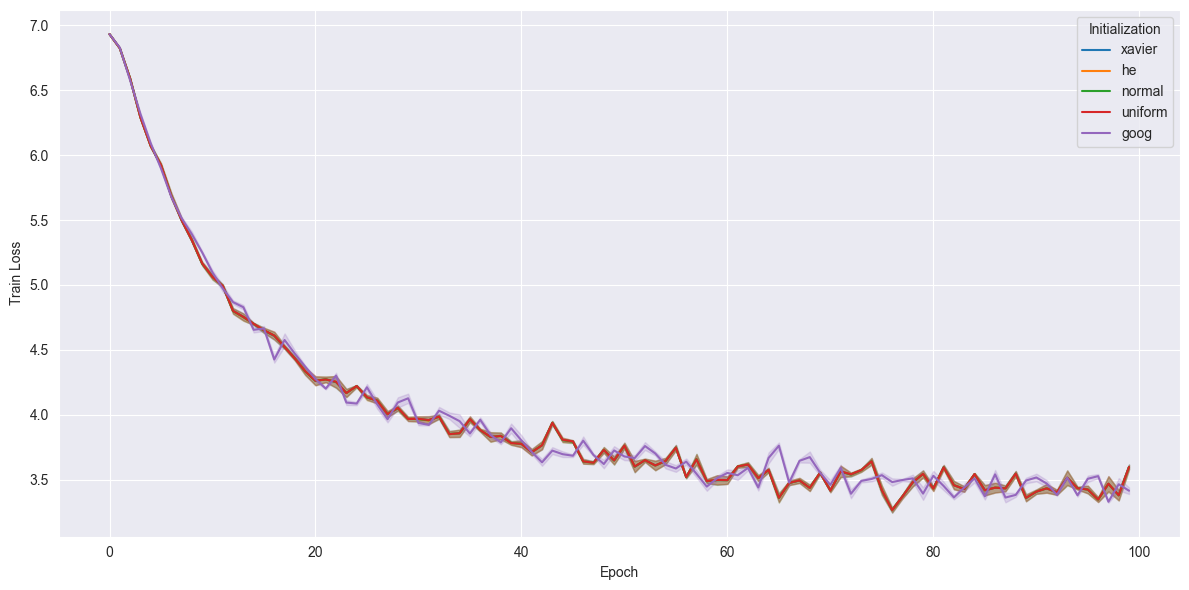

In [11]:
all_data = []

for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None
    
    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["train_loss", "epoch"], pandas=True)
        history = history.dropna(subset=["train_loss", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x="epoch", y="train_loss", hue="initialization", estimator='mean', ci='sd')

# plt.title("Train Loss vs Epoch grouped by Initialization")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend(title="Initialization")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# Initialize empty list to store data
data = []

# Loop over each run to retrieve metrics
for run in runs:
    # Get initialization strategy
    initialization = run.config.get("initialization", "unknown")

    # Extract relevant metrics, ensuring numeric values only
    eval_loss = pd.to_numeric(run.history(keys=["eval_loss"])["eval_loss"], errors="coerce").dropna()
    eval_top1 = pd.to_numeric(run.history(keys=["eval_top1"])["eval_top1"], errors="coerce").dropna()
    eval_top5 = pd.to_numeric(run.history(keys=["eval_top5"])["eval_top5"], errors="coerce").dropna()
    grad_first1 = pd.to_numeric(run.history(keys=["grad_first1_l2"])["grad_first1_l2"], errors="coerce").dropna()
    grad_first2 = pd.to_numeric(run.history(keys=["grad_first2_l2"])["grad_first2_l2"], errors="coerce").dropna()
    grad_first3 = pd.to_numeric(run.history(keys=["grad_first3_l2"])["grad_first3_l2"], errors="coerce").dropna()
    grad_first4 = pd.to_numeric(run.history(keys=["grad_first4_l2"])["grad_first4_l2"], errors="coerce").dropna()
    grad_first5 = pd.to_numeric(run.history(keys=["grad_first5_l2"])["grad_first5_l2"], errors="coerce").dropna()
    grad_last1 = pd.to_numeric(run.history(keys=["grad_last1_l2"])["grad_last1_l2"], errors="coerce").dropna()
    grad_last2 = pd.to_numeric(run.history(keys=["grad_last2_l2"])["grad_last2_l2"], errors="coerce").dropna()
    grad_last3 = pd.to_numeric(run.history(keys=["grad_last3_l2"])["grad_last3_l2"], errors="coerce").dropna()
    grad_last4 = pd.to_numeric(run.history(keys=["grad_last4_l2"])["grad_last4_l2"], errors="coerce").dropna()
    grad_last5 = pd.to_numeric(run.history(keys=["grad_last5_l2"])["grad_last5_l2"], errors="coerce").dropna()

    # Append metrics to data if all lists have values
    for loss, top1, top5, g_first1, g_first2, g_first3, g_first4, g_first5, g_last1, g_last2, g_last3, g_last4, g_last5 in zip(
        eval_loss, eval_top1, eval_top5, grad_first1, grad_first2, grad_first3, grad_first4, grad_first5, grad_last1, grad_last2, grad_last3, grad_last4, grad_last5
    ):
        data.append({
            "initialization": initialization,
            "eval_loss": loss,
            "eval_top1": top1,
            "eval_top5": top5,
            "grad_first1_l2": g_first1,
            "grad_first2_l2": g_first2,
            "grad_first3_l2": g_first3,
            "grad_first4_l2": g_first4,
            "grad_first5_l2": g_first5,
            "grad_last1_l2": g_last1,
            "grad_last2_l2": g_last2,
            "grad_last3_l2": g_last3,
            "grad_last4_l2": g_last4,
            "grad_last5_l2": g_last5,
        })

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Group by initialization and calculate summary statistics for each metric
summary_stats = df.groupby("initialization").agg(["mean", "median", "std"])

# Display the summary statistics
print(summary_stats)

TypeError: 'NoneType' object is not subscriptable

In [19]:
# Check the list of logged metrics for the first run
if runs:
    run = runs[0]
    # Get all keys (metrics) logged to this run
    history = run.history()  # Returns a DataFrame with all metrics logged
    metrics = history.columns  # List of all metric names

    # Display the metric names
    print("Logged Metrics:")
    for metric in metrics:
        print(metric)

    # Optional: Display sample data for each metric
    print("\nSample Data:")
    print(history.head())  # Show the first few rows of data
else:
    print("No runs found in the project.")

Logged Metrics:
train_grad_classifier_last_l2
lr
eval_top1
grad_bn1_first_l2
eval_top5
epoch
train_loss
train_grad_bn1_first_l2
_runtime
_step
eval_loss
grad_classifier_last_l2
train_grad_conv_stem_first_l2
_timestamp
grad_conv_stem_first_l2

Sample Data:
   train_grad_classifier_last_l2  lr  eval_top1  grad_bn1_first_l2  eval_top5  \
0                            NaN NaN        NaN                NaN        NaN   
1                            NaN NaN        NaN        4485.817871        NaN   
2                            NaN NaN        NaN                NaN        NaN   
3                            NaN NaN        NaN                NaN        NaN   
4                            NaN NaN        NaN                NaN        NaN   

   epoch  train_loss  train_grad_bn1_first_l2    _runtime  _step eval_loss  \
0      0         NaN                      NaN  144.823756      0      None   
1      0         NaN                      NaN  144.824754      1      None   
2      0         NaN   

In [20]:
# Initialize empty list to store data
data = []

# Loop over each run to retrieve metrics
for run in runs:
    # Get initialization strategy
    initialization = run.config.get("initialization", "unknown")

    # Extract relevant metrics, ensuring numeric values only
    eval_loss = pd.to_numeric(run.history(keys=["eval_loss"])["eval_loss"], errors="coerce").dropna()
    eval_top1 = pd.to_numeric(run.history(keys=["eval_top1"])["eval_top1"], errors="coerce").dropna()
    eval_top5 = pd.to_numeric(run.history(keys=["eval_top5"])["eval_top5"], errors="coerce").dropna()
    grad_classifier_last_l2 = pd.to_numeric(run.history(keys=["grad_classifier_last_l2"])["grad_classifier_last_l2"], errors="coerce").dropna()
    grad_bn1_first_l2 = pd.to_numeric(run.history(keys=["grad_bn1_first_l2"])["grad_bn1_first_l2"], errors="coerce").dropna()
    grad_conv_stem_first_l2 = pd.to_numeric(run.history(keys=["grad_conv_stem_first_l2"])["grad_conv_stem_first_l2"], errors="coerce").dropna()
    # grad_first4 = pd.to_numeric(run.history(keys=["train_grad_first4_l2"])["train_grad_first4_l2"], errors="coerce").dropna()
    # grad_first5 = pd.to_numeric(run.history(keys=["train_grad_first5_l2"])["train_grad_first5_l2"], errors="coerce").dropna()
    # grad_last1 = pd.to_numeric(run.history(keys=["train_grad_last1_l2"])["train_grad_last1_l2"], errors="coerce").dropna()
    # grad_last2 = pd.to_numeric(run.history(keys=["train_grad_last2_l2"])["train_grad_last2_l2"], errors="coerce").dropna()
    # grad_last3 = pd.to_numeric(run.history(keys=["train_grad_last3_l2"])["train_grad_last3_l2"], errors="coerce").dropna()
    # grad_last4 = pd.to_numeric(run.history(keys=["train_grad_last4_l2"])["train_grad_last4_l2"], errors="coerce").dropna()
    # grad_last5 = pd.to_numeric(run.history(keys=["train_grad_last5_l2"])["train_grad_last5_l2"], errors="coerce").dropna()

    # Append metrics to data if all lists have values
    for loss, top1, top5, g_classifier_last_l2, g_bn1_first_l2, g_conv_stem_first_l2 in zip(
        eval_loss, eval_top1, eval_top5, grad_classifier_last_l2, grad_bn1_first_l2, grad_conv_stem_first_l2
    ):
        data.append({
            "initialization": initialization,
            "eval_loss": loss,
            "eval_top1": top1,
            "eval_top5": top5,
            "grad_classifier_last_l2": g_classifier_last_l2,
            "grad_bn1_first_l2": g_bn1_first_l2,
            "grad_conv_stem_first_l2": g_conv_stem_first_l2,
        })

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Group by initialization and calculate summary statistics for each metric
summary_stats = df.groupby("initialization").agg(["mean", "median", "std"])

# Display the summary statistics
print(summary_stats)

               eval_loss                      eval_top1                    \
                    mean    median       std       mean median        std   
initialization                                                              
goog            0.676778  0.551158  0.404998  80.405718  84.26  12.726949   
he              0.845768  0.680184  0.541014  74.031098  79.58  15.589236   
normal          0.693216  0.552274  0.419367  78.517342  82.32  13.596558   
uniform         0.744234  0.601943  0.390350  78.482061  82.55  12.518836   
xavier          0.759582  0.605189  0.471669  76.499155  81.32  15.041674   

                eval_top5                  grad_classifier_last_l2  \
                     mean median       std                    mean   
initialization                                                       
goog            97.969295  99.02  4.397228              552.024513   
he              96.646253  98.47  6.308088              827.003985   
normal          97.691718  98.94 

Vidíme, že ve všech základních metrikách je nejlepší inicializace goog (neboli ta základní z knihovny timm). He inicializace je naopak nejhorší v těch základních metrikách. Gradienty jsou ještě špatně naprogramované (počet vrstev a názvy), ale jinak by měli fungovat. Zajímavé je, že druhá vrstva u uniform inicialiźace má oproti ostatním inicializacím velmi vysoké std a zároveň u poslední vrstvy dokonce má NaN jako mean a std. Očividně metrika top5 má nízké variace mezi inicializacemi. Normal inicializace je výrazně nejlepší v gradientech a jejich variaci. Další čeho si můžeme všimnout je fakt, že gradienty obecně, neboli jak mean, meadian, tak i std, tak se výrazně liší svojí magnitudou mezi vrstvami. Zatímco v první vrstvě jsou čísla velmi vysoká, tak v druhé jsou zase naopak velmi nízká.

In [2]:
import timm
model = timm.create_model('resnet50', pretrained=False)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

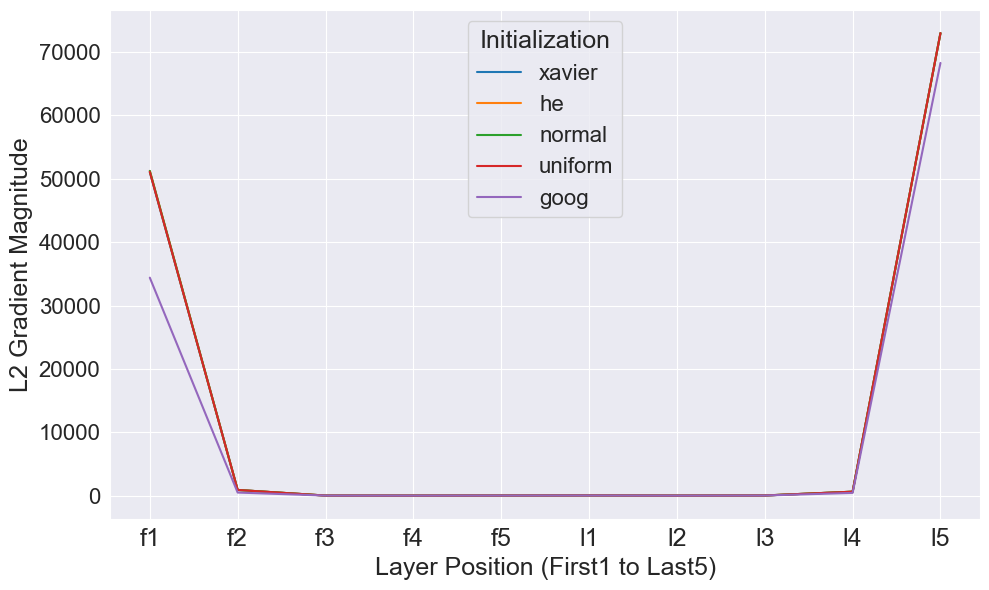

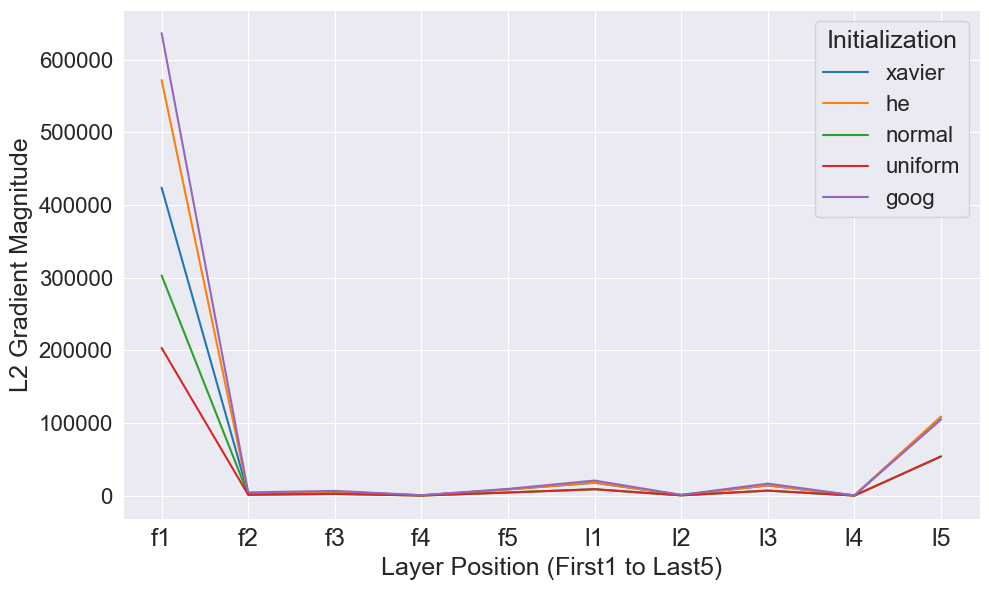

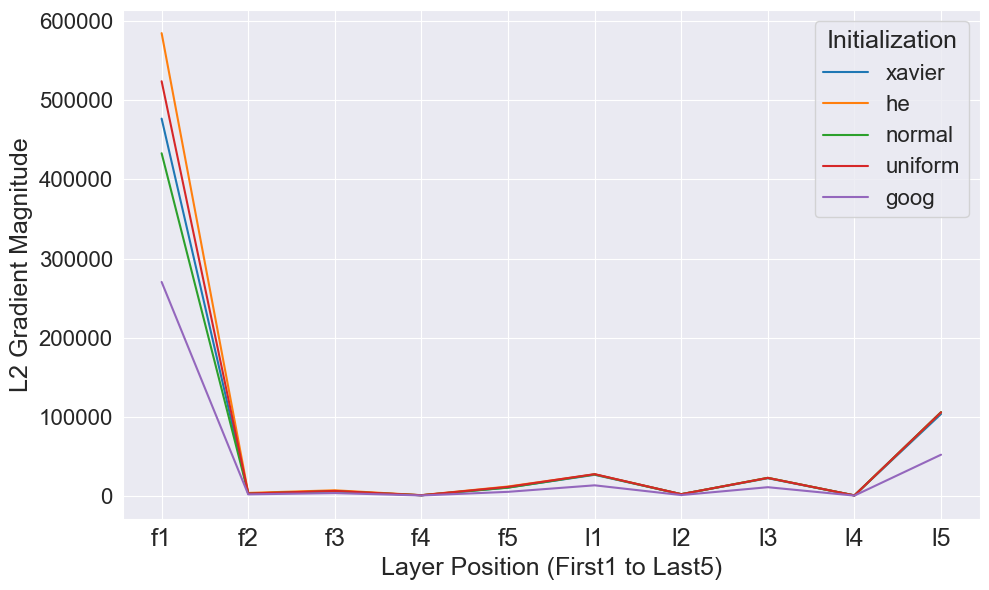

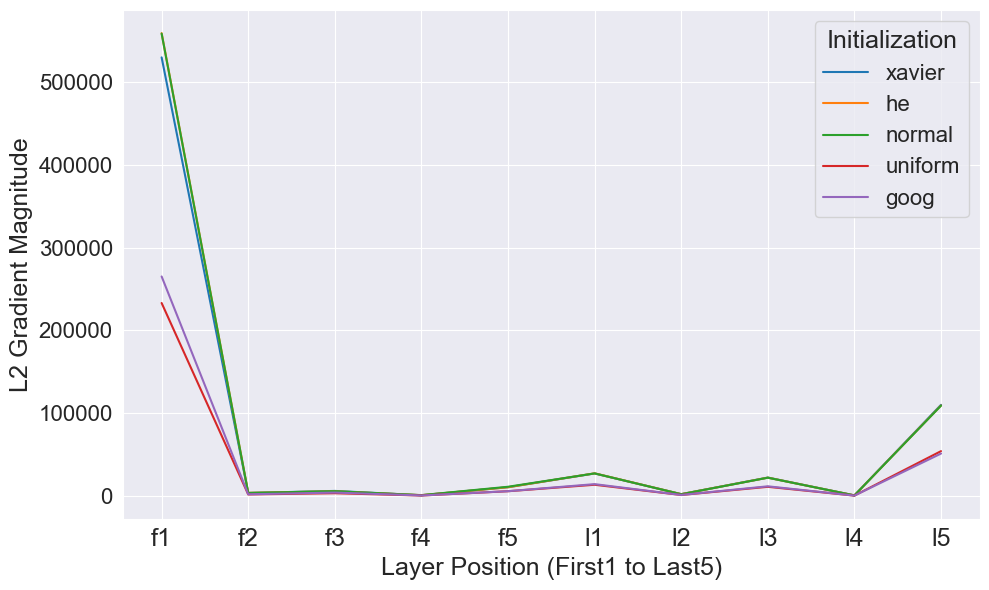

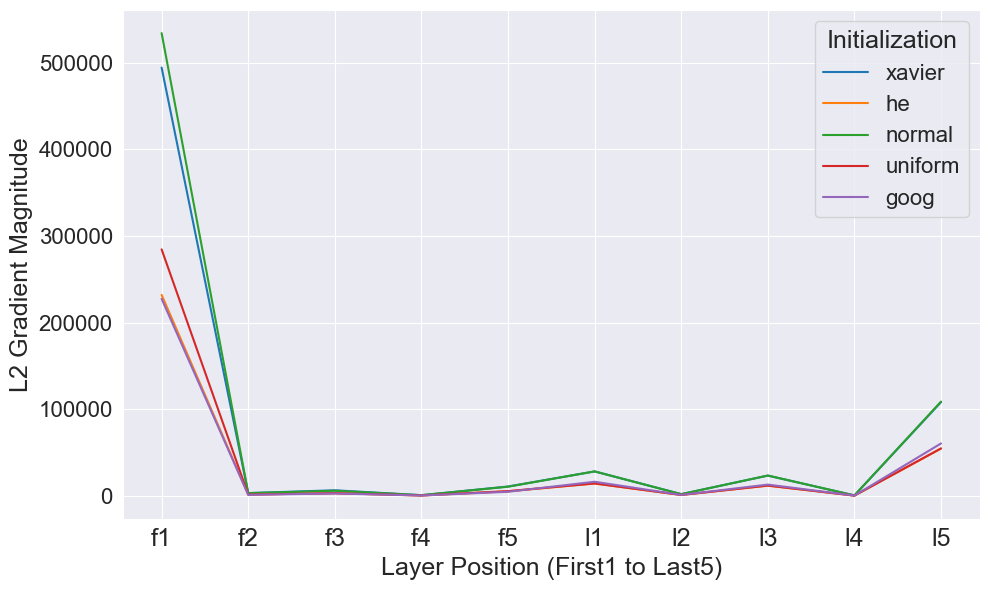

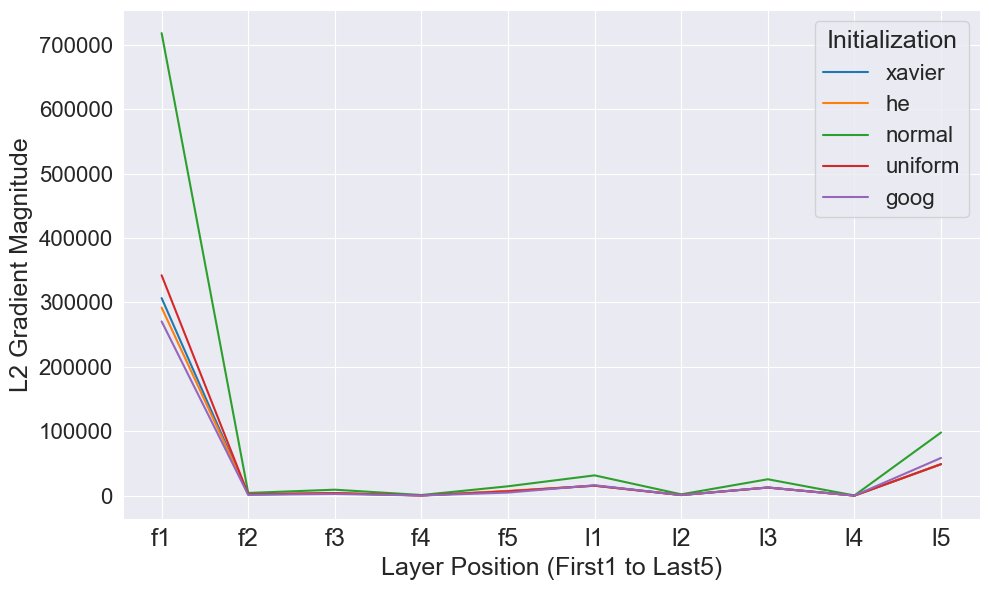

In [3]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate and connect to the project
api = wandb.Api()
project_path = "martinhruska_2000/Try_A3"
runs = api.runs(project_path)

# Filter epochs and gradient keys
epochs_to_plot = [0, 19, 39, 59, 79, 99]
gradient_keys = [f"train_grad_first{i}_l2" for i in range(1, 6)] + [f"train_grad_last{i}_l2" for i in range(1, 6)]

# Group gradients by initialization (excluding "constant")
gradients_by_init = {}

for run in runs:
    init = run.config.get("model_kwargs", {}).get("initialization")
    if init is None or init == "constant":
        continue  # Skip runs without or with 'constant' initialization

    history = run.history(samples=100000)  # ensure full history is fetched

    for epoch in epochs_to_plot:
        row = history[history['_step'] == epoch]
        if row.empty:
            continue

        values = row[gradient_keys].iloc[0].tolist()

        if init not in gradients_by_init:
            gradients_by_init[init] = {}
        gradients_by_init[init][epoch] = values

# Plotting
for epoch in epochs_to_plot:
    plt.figure(figsize=(10, 6))
    for init, grads in gradients_by_init.items():
        if epoch in grads:
            plt.plot(range(1, 11), grads[epoch], label=init)
    #plt.title(f"Gradient Magnitudes at Epoch {epoch}")
    plt.xlabel("Layer Position (First1 to Last5)", fontsize=18)
    plt.ylabel("L2 Gradient Magnitude", fontsize=18)
    plt.xticks(ticks=range(1, 11), labels=[f"f{i}" for i in range(1,6)] + [f"l{i}" for i in range(1,6)], fontsize=18)
    plt.yticks(fontsize=16)
    plt.legend(title="Initialization", fontsize=16, title_fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_14560\2241647983.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization", estimator='mean', ci='sd')


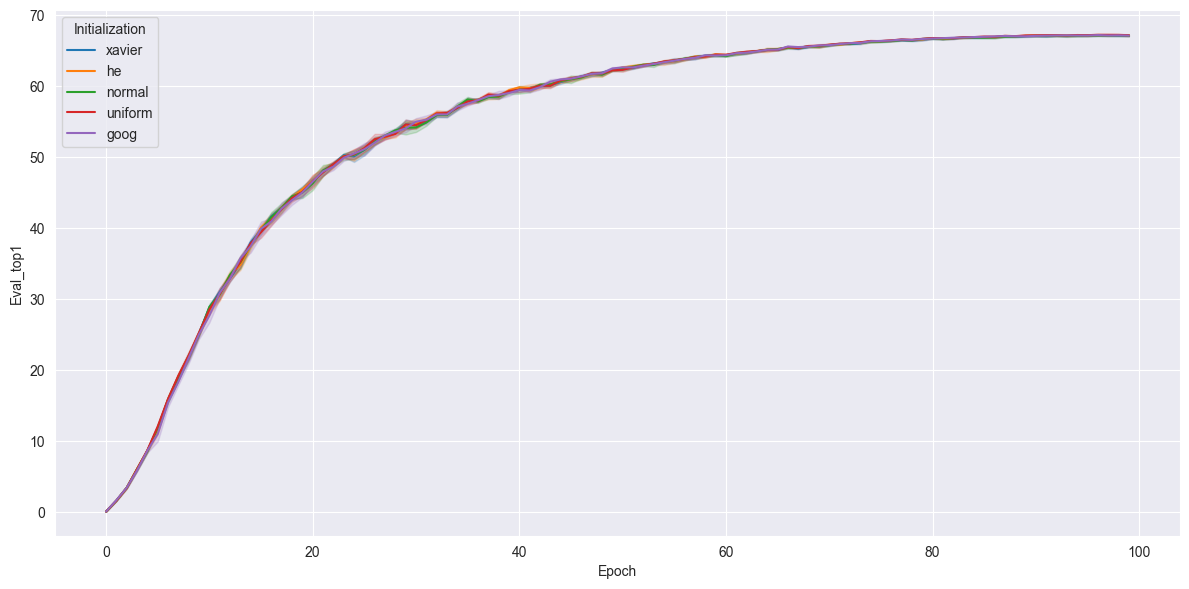

In [8]:
all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None

    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["eval_top1", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_top1", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization", estimator='mean', ci='sd')

#plt.title("Eval_top1 vs Epoch grouped by Initialization")
plt.xlabel("Epoch")
plt.ylabel("Eval_top1")
plt.legend(title="Initialization")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2547019372.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2547019372.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  hue_order = [h.get_label() for h in ax1.get_legend().legendHandles]
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2547019372.py:58: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_last10, x="epoch", y="eval_top1", hue="initialization",


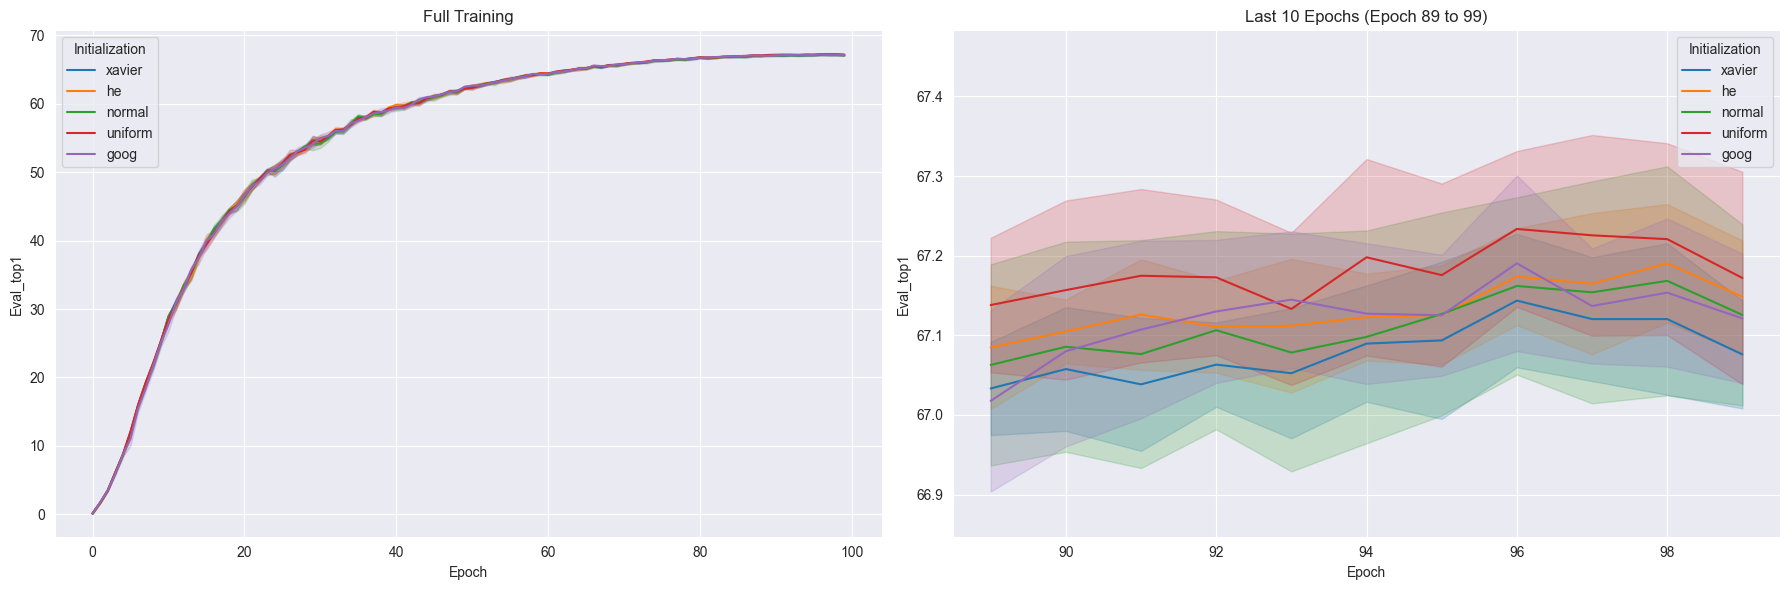

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None

    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["eval_top1", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_top1", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Main plot
sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization", 
             estimator='mean', ci='sd', ax=ax1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Eval_top1")
ax1.set_title("Full Training")
ax1.legend(title="Initialization")
ax1.grid(True)

# Get the last 10 epochs
last_epochs = df_all['epoch'].max()
df_last10 = df_all[df_all['epoch'] >= last_epochs - 10]

# Calculate y-axis limits for zoomed plot
y_min = df_last10['eval_top1'].min()
y_max = df_last10['eval_top1'].max()
y_padding = (y_max - y_min) * 0.1  # Add 10% padding

# Zoomed plot - use the same hue order as the main plot
hue_order = [h.get_label() for h in ax1.get_legend().legendHandles]
sns.lineplot(data=df_last10, x="epoch", y="eval_top1", hue="initialization", 
             estimator='mean', ci='sd', ax=ax2, hue_order=hue_order)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Eval_top1")
ax2.set_title(f"Last 10 Epochs (Epoch {last_epochs-10} to {last_epochs})")
ax2.set_ylim(y_min - y_padding, y_max + y_padding)
ax2.legend(title="Initialization")
ax2.grid(True)

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2771347506.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2771347506.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_last10, x="epoch", y="eval_top1", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2771347506.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

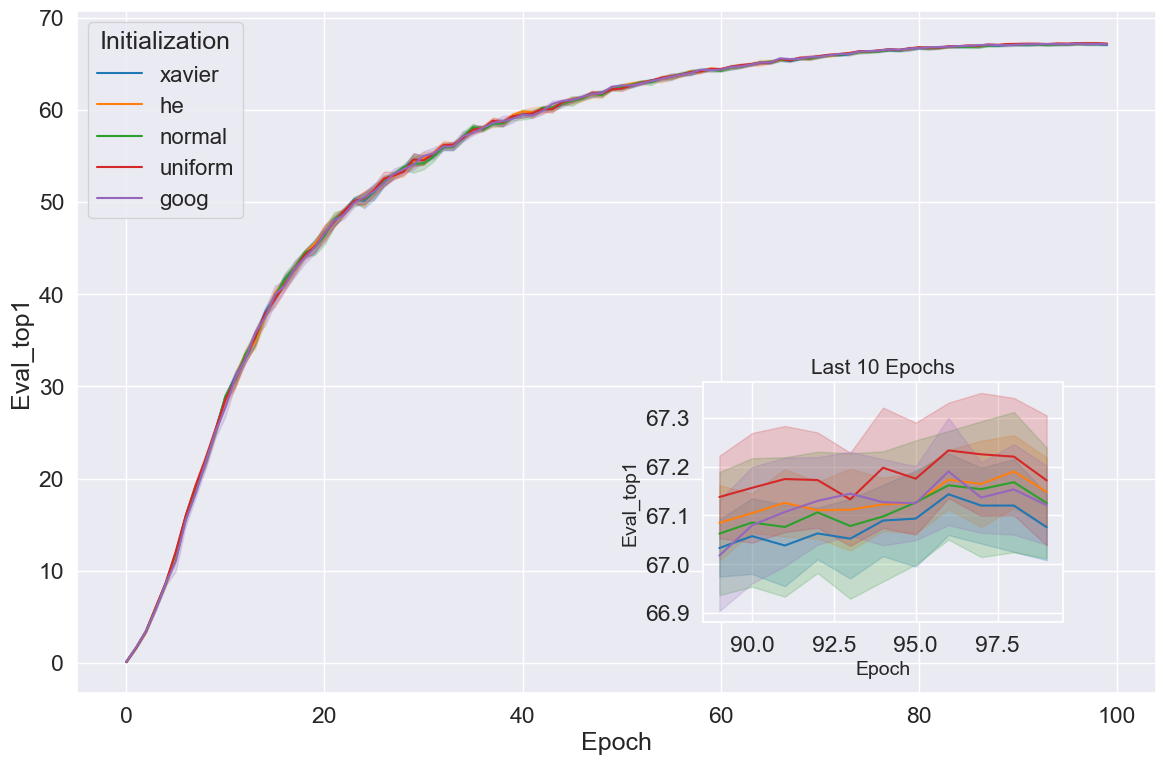

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None

    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["eval_top1", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_top1", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)

# Create main figure
plt.figure(figsize=(12, 8))

# Set larger font scale (default is 1.0)
sns.set_context("notebook", font_scale=1.5)  # Adjust scale as needed (1.3, 1.5, etc.)

plt.figure(figsize=(12, 8))
ax_main = plt.gca()

# Main plot
sns.lineplot(data=df_all, x="epoch", y="eval_top1", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_main)

# Customize labels and titles with larger fonts
ax_main.set_xlabel("Epoch", fontsize=18)  # Adjust fontsize as needed
ax_main.set_ylabel("Eval_top1", fontsize=18)
# ax_main.set_title("Training Performance", fontsize=18)

# Increase legend font size
plt.legend(title="Initialization", title_fontsize=18, fontsize=16)
ax_main.grid(True)

# Inset plot (zoomed-in last 10 epochs)
ax_inset = plt.axes([0.6, 0.2, 0.3, 0.3])
sns.lineplot(data=df_last10, x="epoch", y="eval_top1", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_inset, legend=False)

ax_inset.set_title("Last 10 Epochs", fontsize=15)
ax_inset.set_xlabel("Epoch", fontsize=14)
ax_inset.set_ylabel("Eval_top1", fontsize=14)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2202062730.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="eval_top5", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2202062730.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_last10, x="epoch", y="eval_top5", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2202062730.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

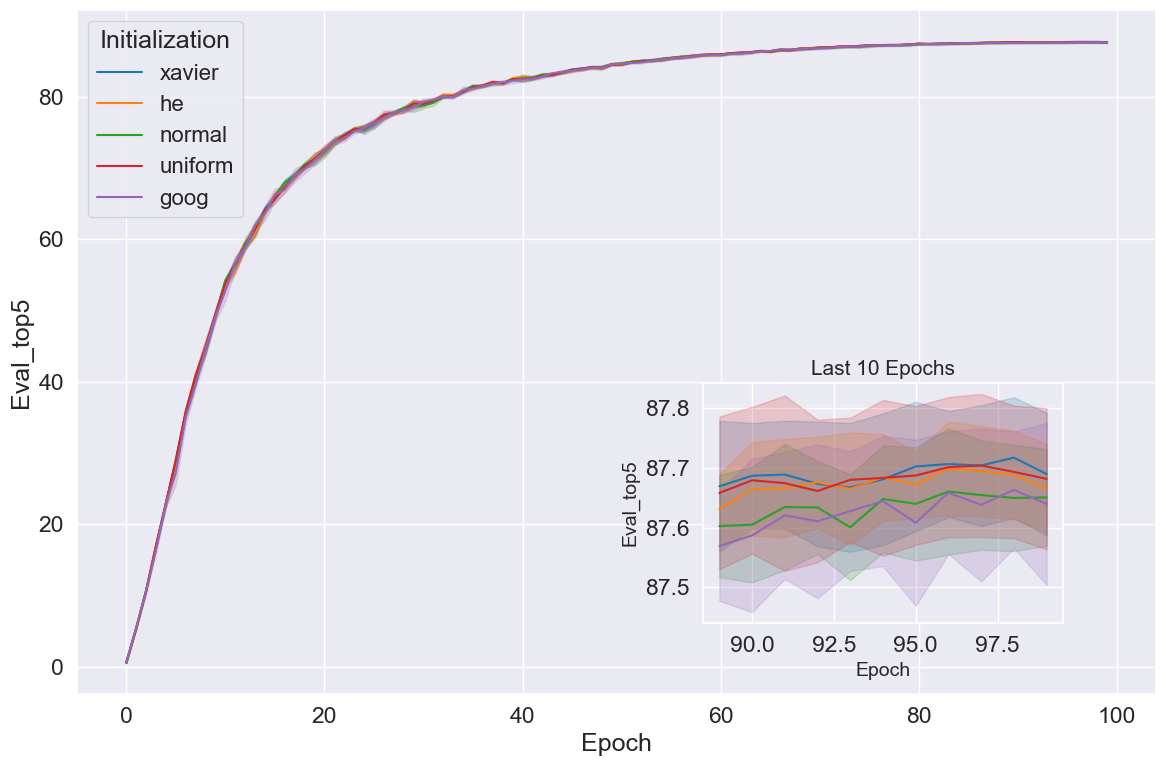

In [13]:
all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None
    
    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["eval_top5", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_top5", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)
# Get the last 10 epochs
last_epochs = df_all['epoch'].max()
df_last10 = df_all[df_all['epoch'] >= last_epochs - 10]
# Create main figure
plt.figure(figsize=(12, 8))

# Set larger font scale (default is 1.0)
sns.set_context("notebook", font_scale=1.5)  # Adjust scale as needed (1.3, 1.5, etc.)

plt.figure(figsize=(12, 8))
ax_main = plt.gca()

# Main plot
sns.lineplot(data=df_all, x="epoch", y="eval_top5", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_main)

# Customize labels and titles with larger fonts
ax_main.set_xlabel("Epoch", fontsize=18)  # Adjust fontsize as needed
ax_main.set_ylabel("Eval_top5", fontsize=18)
# ax_main.set_title("Training Performance", fontsize=18)

# Increase legend font size
plt.legend(title="Initialization", title_fontsize=18, fontsize=16)
ax_main.grid(True)

# Inset plot (zoomed-in last 10 epochs)
ax_inset = plt.axes([0.6, 0.2, 0.3, 0.3])
sns.lineplot(data=df_last10, x="epoch", y="eval_top5", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_inset, legend=False)

ax_inset.set_title("Last 10 Epochs", fontsize=15)
ax_inset.set_xlabel("Epoch", fontsize=14)
ax_inset.set_ylabel("Eval_top5", fontsize=14)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2361758402.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="eval_loss", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2361758402.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_last10, x="epoch", y="eval_loss", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\2361758402.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

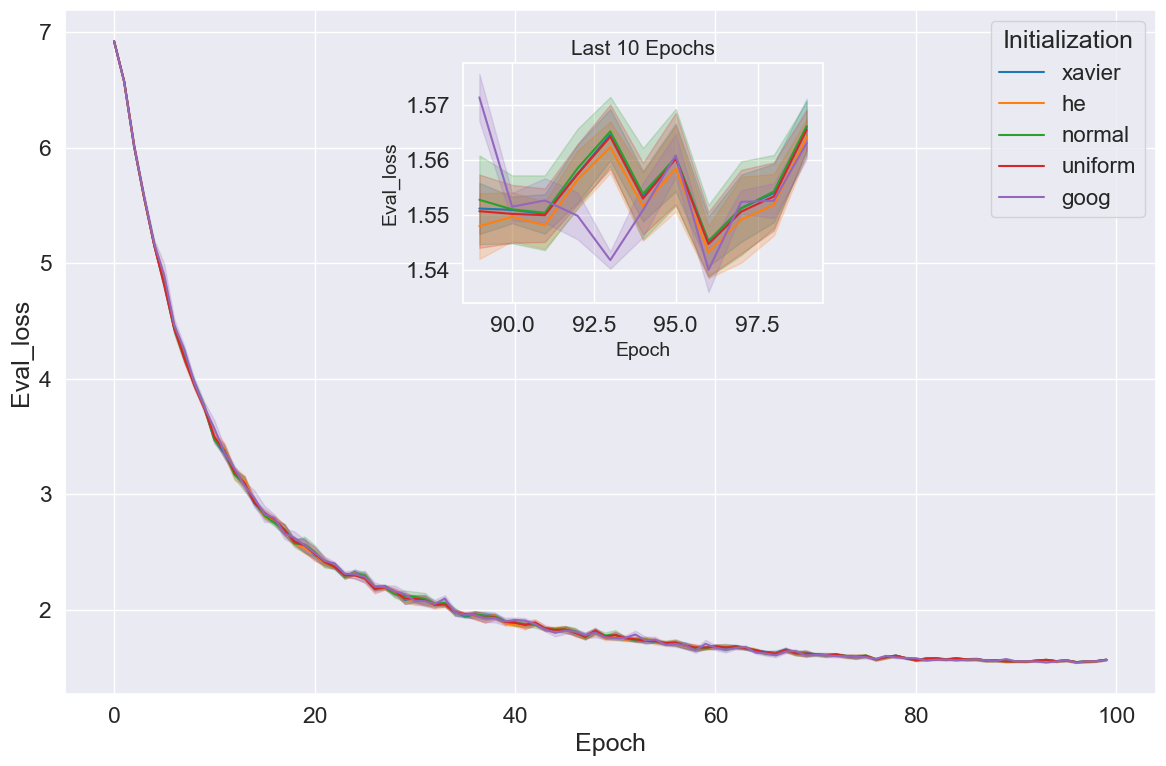

In [20]:
all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None
    
    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["eval_loss", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_loss", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)
# Get the last 10 epochs
last_epochs = df_all['epoch'].max()
df_last10 = df_all[df_all['epoch'] >= last_epochs - 10]
# Create main figure
plt.figure(figsize=(12, 8))

# Set larger font scale (default is 1.0)
sns.set_context("notebook", font_scale=1.5)  # Adjust scale as needed (1.3, 1.5, etc.)

plt.figure(figsize=(12, 8))
ax_main = plt.gca()

# Main plot
sns.lineplot(data=df_all, x="epoch", y="eval_loss", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_main)

# Customize labels and titles with larger fonts
ax_main.set_xlabel("Epoch", fontsize=18)  # Adjust fontsize as needed
ax_main.set_ylabel("Eval_loss", fontsize=18)
# ax_main.set_title("Training Performance", fontsize=18)

# Increase legend font size
plt.legend(title="Initialization", title_fontsize=18, fontsize=16)
ax_main.grid(True)

# Inset plot (zoomed-in last 10 epochs)
ax_inset = plt.axes([0.4, 0.6, 0.3, 0.3])
sns.lineplot(data=df_last10, x="epoch", y="eval_loss", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_inset, legend=False)

ax_inset.set_title("Last 10 Epochs", fontsize=15)
ax_inset.set_xlabel("Epoch", fontsize=14)
ax_inset.set_ylabel("Eval_loss", fontsize=14)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_18156\1295581772.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_all, x="epoch", y="train_loss", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\1295581772.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_last10, x="epoch", y="train_loss", hue="initialization",
C:\Users\marti\AppData\Local\Temp\ipykernel_18156\1295581772.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

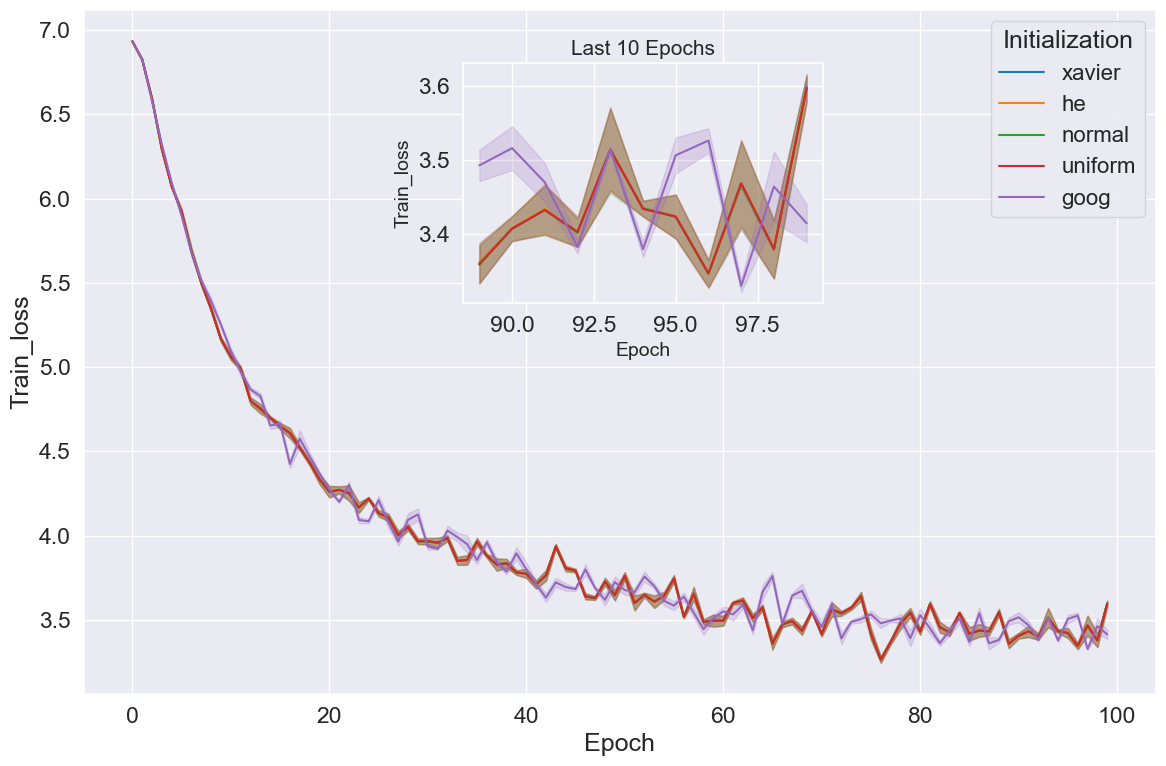

In [22]:
all_data = []
for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle dict or string representation of model_kwargs
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None
    
    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        history = run.history(keys=["train_loss", "epoch"], pandas=True)
        history = history.dropna(subset=["train_loss", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        all_data.append(history)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Combine all runs' histories
df_all = pd.concat(all_data, ignore_index=True)
# Get the last 10 epochs
last_epochs = df_all['epoch'].max()
df_last10 = df_all[df_all['epoch'] >= last_epochs - 10]
# Create main figure
plt.figure(figsize=(12, 8))

# Set larger font scale (default is 1.0)
sns.set_context("notebook", font_scale=1.5)  # Adjust scale as needed (1.3, 1.5, etc.)

plt.figure(figsize=(12, 8))
ax_main = plt.gca()

# Main plot
sns.lineplot(data=df_all, x="epoch", y="train_loss", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_main)

# Customize labels and titles with larger fonts
ax_main.set_xlabel("Epoch", fontsize=18)  # Adjust fontsize as needed
ax_main.set_ylabel("Train_loss", fontsize=18)
# ax_main.set_title("Training Performance", fontsize=18)

# Increase legend font size
plt.legend(title="Initialization", title_fontsize=18, fontsize=16)
ax_main.grid(True)

# Inset plot (zoomed-in last 10 epochs)
ax_inset = plt.axes([0.4, 0.6, 0.3, 0.3])
sns.lineplot(data=df_last10, x="epoch", y="train_loss", hue="initialization", 
             estimator='mean', ci='sd', ax=ax_inset, legend=False)

ax_inset.set_title("Last 10 Epochs", fontsize=15)
ax_inset.set_xlabel("Epoch", fontsize=14)
ax_inset.set_ylabel("Train_loss", fontsize=14)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

In [5]:
for run in runs:
    print(run)

<Run martinhruska_2000/Try_A3/yegv88fr (finished)>
<Run martinhruska_2000/Try_A3/d97vq92z (finished)>
<Run martinhruska_2000/Try_A3/znw3zl2a (finished)>
<Run martinhruska_2000/Try_A3/mq6annzx (finished)>
<Run martinhruska_2000/Try_A3/q7wnjpgx (finished)>
<Run martinhruska_2000/Try_A3/6r0sq3f6 (finished)>
<Run martinhruska_2000/Try_A3/vhh24dix (finished)>
<Run martinhruska_2000/Try_A3/44eqnuy5 (finished)>
<Run martinhruska_2000/Try_A3/htzh798j (finished)>
<Run martinhruska_2000/Try_A3/5tkt6jc2 (finished)>
<Run martinhruska_2000/Try_A3/itbbkzsc (finished)>
<Run martinhruska_2000/Try_A3/u6mkfo5i (finished)>
<Run martinhruska_2000/Try_A3/8bkf2cqy (finished)>
<Run martinhruska_2000/Try_A3/v3ek48fp (finished)>
<Run martinhruska_2000/Try_A3/p5dicuqg (finished)>
<Run martinhruska_2000/Try_A3/ueyze75k (finished)>
<Run martinhruska_2000/Try_A3/1ely8wtb (finished)>
<Run martinhruska_2000/Try_A3/t5v56h2g (finished)>
<Run martinhruska_2000/Try_A3/rt3ke2q7 (finished)>
<Run martinhruska_2000/Try_A3/1

In [7]:
import pandas as pd
import numpy as np

all_metrics = []

for run in runs:
    config = run.config or {}
    model_kwargs = config.get("model_kwargs", {})
    
    # Handle initialization
    initialization = None
    if isinstance(model_kwargs, dict):
        initialization = model_kwargs.get("initialization")
    elif isinstance(model_kwargs, str):
        try:
            initialization = eval(model_kwargs).get("initialization")
        except:
            initialization = None

    if initialization is None or initialization == "constant":
        continue  # Skip runs without or with 'constant' initialization

    try:
        # Fetch all needed metrics
        history = run.history(keys=["train_loss", "eval_loss", "eval_top1", "epoch"], pandas=True)
        history = history.dropna(subset=["eval_top1", "epoch"])
        history["initialization"] = initialization
        history["run_id"] = run.id
        
        # Find the best epoch (where eval_top1 is max)
        best_epoch_idx = history["eval_top1"].idxmax()
        best_metrics = history.loc[best_epoch_idx].to_dict()
        
        all_metrics.append(best_metrics)
    except Exception as e:
        print(f"Failed to fetch history for run {run.id}: {e}")

# Convert to DataFrame
df_best_metrics = pd.DataFrame(all_metrics)

# Group by initialization and compute mean ± std
summary = df_best_metrics.groupby("initialization").agg({
    "train_loss": ["mean", "std"],
    "eval_loss": ["mean", "std"],
    "eval_top1": ["mean", "std"],
    "epoch": ["mean", "std"]
}).round(4)

# Print the summary
print("Best Epoch Performance (Mean ± Std)")
print("-----------------------------------")
print(summary)

Best Epoch Performance (Mean ± Std)
-----------------------------------
               train_loss         eval_loss         eval_top1         epoch  \
                     mean     std      mean     std      mean     std  mean   
initialization                                                                
goog               3.4828  0.0570    1.5465  0.0132   67.1932  0.1068  97.0   
he                 3.4218  0.1004    1.5499  0.0087   67.1996  0.0742  96.4   
normal             3.3436  0.0147    1.5487  0.0019   67.1788  0.1340  96.8   
uniform            3.3961  0.0531    1.5489  0.0106   67.2492  0.1124  97.0   
xavier             3.3953  0.0703    1.5504  0.0053   67.1584  0.0793  96.2   

                        
                   std  
initialization          
goog            1.4142  
he              2.3022  
normal          1.0954  
uniform         1.0000  
xavier          1.4832  
